# Урок 4. Деревья решений. Домашняя работа

В коде из методички реализуйте один или несколько критериев останова: количество листьев, количество используемых признаков, глубина дерева и т. д.
Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.

*В данной работе критерий останова глубина дерева реализован в модели дерева, которую я изменила для целей регрессии

In [641]:
import matplotlib.pyplot as plt
import random
import numpy as np
from sklearn import datasets
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor, plot_tree
import pandas as pd

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [642]:
# сгенерируем набор данных для применения дерева решений (задача регрессии)
X, y, coef = datasets.make_regression(n_samples=2000, n_features=5, n_informative=2, n_targets=1, 
                                      noise=5, coef=True, random_state=100)
print(X, y, coef)

[[ 0.28721299  0.01632287 -0.3785028  -0.20958795 -0.63596982]
 [-0.23623064  1.33875245  0.63558577  1.7339144  -0.19237388]
 [ 0.21232514  0.31666913  0.88835121 -0.46794493 -0.72235738]
 ...
 [ 0.93012042 -0.80076201 -0.98601687 -1.15390595 -0.61554383]
 [ 0.01971107 -0.36580059  1.39287221  2.27510798  0.33128519]
 [ 0.77289699  0.16667046  1.15950394 -0.66846384  0.38863809]] [ -0.53136967 -32.45850466 -20.42381448 ...  65.07645971  22.3667534
  94.58446812] [94.58832789  0.          0.          0.         43.93666682]


За функционал качества при работе с деревом решений принимается функционал вида

$$Q(X_{m}, j, t) = H(X_{m}) - \frac{|X_{l}|}{|X_{m}|}H(X_{l}) - \frac{|X_{r}|}{|X_{m}|}H(X_{r}),$$

его еще называют **приростом информации** (information gain).

где $X_{m}$ - множество объектов, попавших в вершину на данном шаге, $X_{l}$ и $X_{r}$ - множества, попадающие в левое и правое поддерево, соответственно, после разбиения. $H(X)$ - _критерий информативности_. Он оценивает качество распределения объектов в подмножестве и тем меньше, чем меньше разнообразие ответов в $X$, соответственно, задача обучения состоит в его минимизации и, соответственно, максимизации $Q(X_{m}, j, t)$ на данном шаге. Последний, по сути, характеризует прирост качества на данном шаге.

В формуле значения критериев информативности нормируются - домножаются на долю объектов, ушедших в соответствующее подмножество. Например, если у нас множество в узле разбилось на два подмножества размером в 9990 объектов и 10 объектов, но при этом в первом подмножестве все объекты будут принадлежать к одному классу (то есть иметь минимальное значение разброса), а во втором - к разным, то в целом разбиение будет считаться хорошим, так как подавляющее большинство отсортировано правильно.

В случае **регрессии** разброс будет характеризоваться дисперсией или же *среднеквадратичным отклонением*, поэтому критерий информативности будет записан в виде

$$H(X) = \frac{1}{X}\sum_{i\in X}(y_{i} - \bar{y}(X))^{2},$$

или же *среднеабсолютным отклонением*:

$$H(X) = \frac{1}{X}\sum_{i\in X}(|y_{i} - \bar{y}(X)|),$$


где $\bar{y}(X)$ - среднее значение ответа в выборке $X$:

$$\bar{y}(X) = \frac{1}{|X|}\sum_{i\in X}y_{i}.$$

## Реализация дерева решений<a class='anchor' id='implement_dt'>

In [643]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [644]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):  
        prediction = self.labels.mean()
        return prediction        

In [645]:
# Расчет критерия MSE

def mse(labels):
    mean = labels.mean()
    return np.mean((labels - mean)**2)

$$H(X_{m}) - \frac{|X_{l}|}{|X_{m}|}H(X_{l}) - \frac{|X_{r}|}{|X_{m}|}H(X_{r}),$$


In [646]:
# Расчет прироста для регрессии

def gain(left_labels, right_labels, root_mse):

    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return root_mse - p * mse(left_labels) - (1 - p) * mse(right_labels)

In [647]:
# Разбиение датасета в узле

def split(data, labels, column_index, t):
    
    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)
        
    true_data = data[left]
    false_data = data[right]
    
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [648]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels, min_samples_leaf):

    root_mse = mse(labels)

    best_gain = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique(data[:, index])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 3 объектов
            if len(true_data) < min_samples_leaf or len(false_data) < min_samples_leaf:
                continue
            
            current_gain = gain(true_labels, false_labels, root_mse)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index

In [649]:
import time
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels, min_samples_leaf=1, max_depth=None, count = 0):

    gain, t, index = find_best_split(data, labels, min_samples_leaf)
    
    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if gain == 0 or ((max_depth!= None) and (count>=max_depth)):
        return Leaf(data, labels)
    
    count +=1

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels, min_samples_leaf, max_depth, count)

#     print(time.time(), true_branch)
    false_branch = build_tree(false_data, false_labels, min_samples_leaf, max_depth, count)
    
#     print(time.time(), false_branch)
    
    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [650]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [651]:
def predict(data, tree):
    
    predictions = []
    for obj in data:
        prediction = classify_object(obj, tree)
        predictions.append(prediction)
    return predictions

In [652]:
# Разобьем выборку на обучающую и тестовую

from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(X, 
                                                                    y, 
                                                                    test_size=0.3,
                                                                    random_state=1)

In [653]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels, min_samples_leaf=3, max_depth=8)

In [654]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)

In [655]:
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

Рассчитаем метрики mse, mae, r2-score


In [656]:
def mse_score(y, y_pred):
    return np.mean((y - y_pred)**2)

In [657]:
def mae_score(y, y_pred):
    return np.mean(abs(y - y_pred))

In [658]:
def r2_score(y, y_pred):
    return 1 - mse_score(y, y_pred)/mse(y)

In [659]:
print(f'Наша модель дерева тест: mse {round(mse_score(test_labels, answers),4)}, mae {round(mae_score(test_labels, answers),4)}, r2 {round(r2_score(test_labels, answers),4)}')

Наша модель дерева тест: mse 211.9008, mae 10.7704, r2 0.9811


Посмотрим работу нашей модели на обучающей выборке

In [660]:
print(f'Наша модель дерева на трейн: mse {round(mse_score(train_labels, train_answers),4)}, mae {round(mae_score(train_labels, train_answers),4)}, r2 {round(r2_score(train_labels, train_answers),4)}')

Наша модель дерева на трейн: mse 66.8976, mae 6.1523, r2 0.9935


Сравним результаты работы нашей модели и DecisionTreeRegressor и рассчитаем метрики

In [661]:
tree = DecisionTreeRegressor(max_depth=8, min_samples_leaf=3)

tree.fit(train_data, train_labels)
answers_DecisionTreeRegressor = tree.predict(test_data)
train_answers_DecisionTreeRegressor = tree.predict(train_data)

In [662]:
print(f'Модель sklearn DecisionTreeRegressor тест: mse {round(mse_score(test_labels, answers_DecisionTreeRegressor),4)}, mae {round(mae_score(test_labels, answers_DecisionTreeRegressor),4)}, r2 {round(r2_score(test_labels, answers_DecisionTreeRegressor),4)}')

Модель sklearn DecisionTreeRegressor тест: mse 198.7007, mae 10.5166, r2 0.9822


Посмотрим работу DecisionTreeRegressor на обучающей выбоорке

In [663]:
print(f'Модель sklearn DecisionTreeRegressor трейн: mse {round(mse_score(train_labels, train_answers_DecisionTreeRegressor),4)}, mae {round(mae_score(train_labels, train_answers_DecisionTreeRegressor),4)}, r2 {round(r2_score(train_labels, train_answers_DecisionTreeRegressor),4)}')

Модель sklearn DecisionTreeRegressor трейн: mse 66.8976, mae 6.1523, r2 0.9935


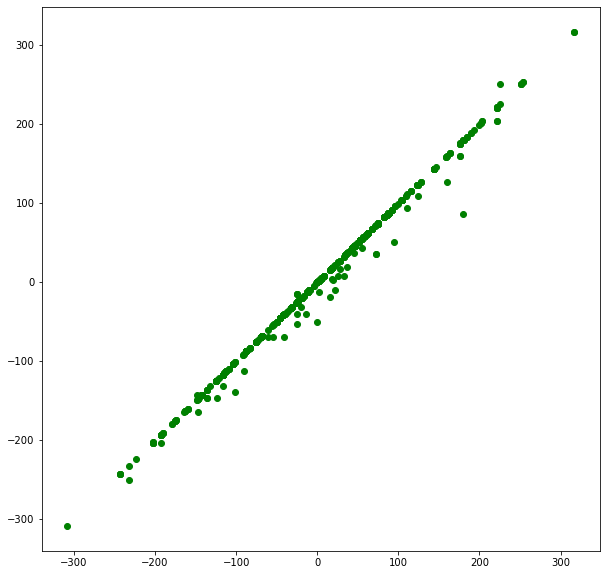

In [664]:
plt.figure(figsize=(10, 10))
plt.scatter(answers, answers_DecisionTreeRegressor, color='green')

На графике видно, что наша модель предсказывает значения (на тесте) очень близкие к значениям DecisionTreeRegressor sklearn, значения mse тоже близки, показатель r2 почти одинаковый, достаточно высокий

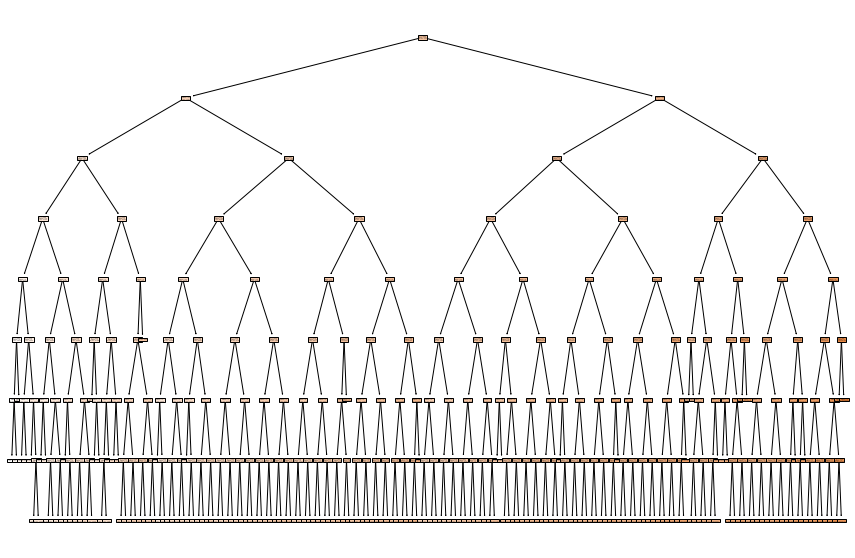

In [667]:
features = ['x0', 'x1', 'x2', 'x3', 'x4']

fig, ax = plt.subplots(figsize=(15, 10))
plot_tree(tree, ax=ax, feature_names=list(features), filled=True, impurity=False);

Обе модели (наша и из библиотеки sklearn) на трейне и тесте дают соответственно r2 0,99 и 0,98 при максимальной глубине дерева 8, минимальном количестве объектов в листе 3. 
При снижении максимальной глубины дерева до 5, r2 становится 0,95 и на тесте, и на трейне. Для целей данной задачи считаю правильным оставить максимальную глубину дерева 8. При ней показатель r2 на тесте очень высокий.